In [232]:
import festim as F
import fenics as f
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from festim import Export

Creating 2D mesh with FEniCS and marking its subdomains

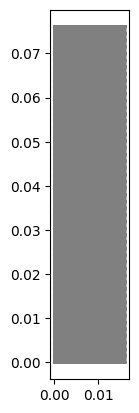

In [233]:
from fenics import Point, RectangleMesh, CompiledSubDomain, MeshFunction, plot

# creating a mesh with FEniCS
nx = ny = 50
# mesh_fenics = UnitSquareMesh(nx, ny)

mesh_fenics = RectangleMesh(Point(0.0, 0.0), Point(0.0162, 0.0761), nx, ny)

# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

left_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0, tol)', tol=1e-14)
right_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0.0162, tol)', tol=1e-14)
bottom_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0, tol)', tol=1e-14)
top_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0.0761, tol)', tol=1e-14)

surface_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)

# Surface ids
left_id = 1
top_id = 2
right_id = 3
bottom_id = 4
left_surface.mark(surface_markers, left_id)
right_surface.mark(surface_markers, right_id)
top_surface.mark(surface_markers, top_id)
bottom_surface.mark(surface_markers, bottom_id)

plot(mesh_fenics)

Functions defining flibe properties:

In [234]:
def density_flibe(T):
    return 2413 - 0.488 * T  # kg/m3


def viscosity_flibe(T):
    e = 2.718281828459045
    return 1.16e-04 * e ** (3755 / (T + DOLFIN_EPS))  # Pa.s


def beta_flibe(T):
    return 1.8319e-04 + 5.55e-08 * T  # K-1


def plot_properties():
    T = np.linspace(400, 1200, 1000)

    mu = viscosity_flibe(T)
    rho = density_flibe(T)
    beta = beta_flibe(T)

    plt.figure()
    mu *= 1e03
    plt.plot(T, mu, label="viscosity")
    plt.ylim(0, 30)
    plt.legend()

    plt.figure()
    plt.plot(T, rho, label="density")
    plt.ylim(1800, 2150)
    plt.legend()

    plt.figure()
    beta *= 1e04
    plt.plot(T, beta, label="Thermal expansion")
    plt.ylim(1.6, 2.8)
    plt.legend()

    plt.show()


CFD simulation function:

In [235]:

def velocity_field(T_cold, T_hot, my_mesh, results_folder="Results/"):
    T_bulk = ((T_hot - T_cold) / 2) + T_cold

    V_ele = VectorElement("CG", my_mesh.ufl_cell(), 2)
    Q_ele = FiniteElement("CG", my_mesh.ufl_cell(), 1)
    T_ele = FiniteElement("CG", my_mesh.ufl_cell(), 1)
    W = FunctionSpace(my_mesh, MixedElement([V_ele, Q_ele, T_ele]))

    upT = Function(W)
    upT_old = Function(W)
    u, p, T = split(upT)
    v, q, S = TestFunctions(W)

    for factor in [1e-03, 1e-02, 1e-01, 1]:
        print("Running for factor={:.1e}".format(factor))

        g = Constant((0, -9.81))  # gravity acceleration in m/s2
        mu = viscosity_flibe(T_bulk)  # dynamic viscosity in kg/m/s
        rho = density_flibe(T_bulk)  # density in kg/m3
        rho_0 = density_flibe(T_bulk)  # density at T_cold
        cp = 2386  # heat capacity in J/(kg.K)
        thermal_cond = 1.1  # thermal conductivity in W/(m.K)
        beta = beta_flibe(T_bulk) * factor

        # CFD momentum
        F = (
            rho_0 * inner(dot(grad(u), u), v) * dx
            - inner(p, div(v)) * dx
            + mu * inner(grad(u), grad(v)) * dx
            + inner(rho_0 * beta * (T - T_bulk) * g, v) * dx
        )

        # CFD continuity
        F -= inner(q, div(u)) * dx

        # Heat transfer
        F += rho * cp * inner(dot(grad(T), u), S) * dx
        F += inner(thermal_cond * grad(T), grad(S)) * dx

        bcs = [
            DirichletBC(W.sub(0), Constant((0, 0)), "on_boundary"),
            DirichletBC(W.sub(2), T_hot, "on_boundary && x[0] == 0"),
            DirichletBC(W.sub(2), T_cold, "on_boundary && x[0] == 0.0162"),
        ]

        solve(
            F == 0,
            upT,
            bcs=bcs,
            solver_parameters={
                "newton_solver": {
                    "linear_solver": "mumps",
                    "absolute_tolerance": 1e-09,
                    "relative_tolerance": 1e-09,
                    "maximum_iterations": 25,
                }
            },
        )

        upT_old.assign(upT)

    u, p, T = upT.split()


    # XDMFFile(results_folder + "velocity_field.xdmf").write(u)
    # XDMFFile(results_folder + "temperature_field.xdmf").write(T)


    # TFile = F.XDMFExport("T", label=f"dt={T_hot - T_cold}", filename="temperature_field.xdmf", mode="last", checkpoint=True, folder=results_folder)
    # TFile.define_xdmf_file()
    # TFile.write(T)


    # self.file.write_checkpoint(
    #             self.ufunction,
    #             self.label,
    #             t,
    #             f.XDMFFile.Encoding.HDF5,
    #             append=self.append,
    #         )
    # XDMFFile(results_folder + "temperature_field.xdmf").write(T)

    return u, p, T


Diffusion Simulation:

In [236]:
def my_simulation(T_array, mesh_fenics, velocity):
    """
    Takes in a list of temperatures and a set mesh and returns a list of diffusion coefficients that correspond to each temperature
    """
    k_array = []
    for i in range(len(T_array)):
        # setting up current simulation
        model_2d = F.Simulation()

        # D, E_d source: "nakamura_hydrogen_2015"
        # Thermal cond source: https://dspace.mit.edu/bitstream/handle/1721.1/123988/Romatoski_SaltPropertyReview02.pdf?sequence=1&isAllowed=y#:~:text=From%20the%20data%20collected%2C%20the,an%20uncertainty%20of%20%C2%B110%25.
        flibe_mat = F.Material(
            id=1,
            D_0=1.508521565198744e-08,
            E_D=0.23690444592353738,
            thermal_cond=1.1
            )
        model_2d.materials = F.Materials([flibe_mat])

        # creating mesh with festim
        model_2d.mesh = F.Mesh(
            mesh=mesh_fenics,
            volume_markers=volume_markers,
            surface_markers=surface_markers
        )

        # setting up steady state heat transfer problem
        # model_2d.T = F.HeatTransferProblem(transient=False)

        xdmftemp = F.TemperatureFromXDMF(T_array[0][0], T_array[0][1])
        xdmftemp.create_functions(model_2d.mesh)
        # Temp = xdmftemp.create_functions(mesh_fenics)
        model_2d.T = xdmftemp.T_n

        # model_2d.T = F.TemperatureFromXDMF(T_array[0][0], T_array[0][1])

        plot(model_2d.T)


        # setting up T source
        model_2d.sources = [
            F.Source(
                value=1.84*10**5/(0.0761*0.0162), 
                volume=1, 
                field=0
                )
            ]

        
        # setting up transport boundary conditions
        tritium_transport_bcs = [
            F.DirichletBC(
                surfaces=[top_id, bottom_id, right_id], 
                value=0, 
                field=0
                )
        ]

        model_2d.boundary_conditions = tritium_transport_bcs

        
        # simulation parameters and running model
        model_2d.settings = F.Settings(
            transient=False,
            absolute_tolerance=1e-09,
            relative_tolerance=1e-09,
        )

        model_2d.initialise()
        # model_2d.run()


        # adding advection
        model_2d.initialise() # reinitialisation is needed

        hydrogen_concentration = model_2d.h_transport_problem.mobile.solution
        test_function_solute = model_2d.h_transport_problem.mobile.test_function

        advection_term = inner(dot(grad(hydrogen_concentration), velocity), test_function_solute) * model_2d.mesh.dx

        model_2d.h_transport_problem.F += advection_term


        # setting up exports
        export_folder = "BABY_2D_results"

        derived_quantities = F.DerivedQuantities(filename=export_folder + "/simulation.csv")

        derived_quantities.derived_quantities = [
            F.SurfaceFlux(field="solute", surface=1),
            F.SurfaceFlux(field="solute", surface=2),
            F.SurfaceFlux(field="solute", surface=3),
            F.SurfaceFlux(field="solute", surface=4),
            F.AverageVolume(field="solute", volume=1)
            ]

        model_2d.exports = F.Exports([
            F.XDMFExport("solute", folder=export_folder),
            F.XDMFExport("retention", folder=export_folder),
            F.XDMFExport("T", folder=export_folder),
            derived_quantities
            ])


        model_2d.run()
        plot(hydrogen_concentration)
        plot(velocity)
        plt.show()
        

        # reading results
        my_data = np.genfromtxt(export_folder + "/simulation.csv", names=True, delimiter=",")

        flux_1 = my_data["Flux_surface_1_solute"]
        flux_2 = my_data["Flux_surface_2_solute"]
        flux_3 = my_data["Flux_surface_3_solute"]
        flux_4 = my_data["Flux_surface_4_solute"]

        # calculating diffusion coefficient
        total_flux = abs(flux_1 + flux_2 + flux_3 + flux_4)

        average_conc = my_data["Average_solute_volume_1"]

        A = 0.0761*0.0162

        k = total_flux/(A*average_conc)

        k_array.append(k)
        

    return k_array

Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00


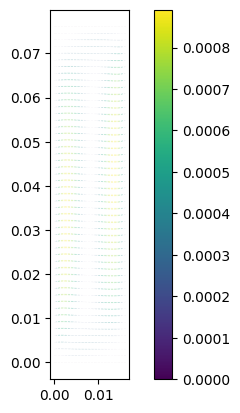

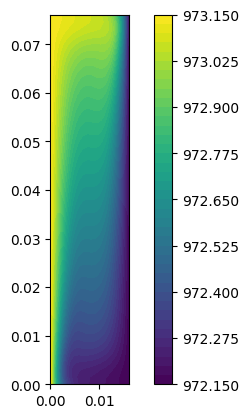

Transposed is only defined for rank 2 tensors.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


UFLException: Transposed is only defined for rank 2 tensors.

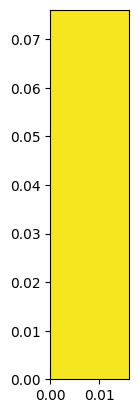

In [237]:
if __name__ == "__main__":
    # plot_properties()

    # T_cold_temps = [1, 3, 5]
    # T_hot = 700 + 273.15
    # for dt in T_cold_temps:
    #     T_cold = T_hot - dt
    #     foldername = f"Results/dt={dt}/"
    #     velocity_field(T_cold=T_cold, T_hot=T_hot, my_mesh=my_mesh,  results_folder=foldername)


    dt_array = [1]
    foldername = f"Results/dt={dt_array[0]}/"
    T_array = [(foldername + "temperature_field.xdmf", f"dt={dt_array[0]}")]
    T_hot = 700 + 273.15
    T_cold = T_hot - dt_array[0]
    u, p, T = velocity_field(T_cold=T_cold, T_hot=T_hot, my_mesh=mesh_fenics, results_folder=foldername)

    XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(T, f"dt={dt_array[0]}", 1, XDMFFile.Encoding.HDF5)
    XDMFFile(foldername + "velocity_field.xdmf").write(u)

    # Tfile = XDMFFile("Test" + foldername + "temperature_field.xdmf").write(T)
    # XDMFFile().write_checkpoint(T, f"dt={dt_array[0]}", 1.0, XDMFFile.Encoding.HDF5)

    # TFile = F.XDMFExport("T", label=f"dt={T_hot - T_cold}", filename="temperature_field.xdmf", mode="last", checkpoint=True, folder="Test" + foldername)
    # TFile.define_xdmf_file()
    # TFile.write_checkpoint()

    # T = load_xdmf(mesh_fenics, foldername + "temperature.xdmf", "temperature")
    # CF = plot(T, cmap="inferno", levels=100)
    # plt.colorbar(CF)
    # plt.show()

    CS = plot(u)
    plt.colorbar(CS)
    plt.show()

    TS = plot(T)
    plt.colorbar(TS)
    plt.show()

    k_array = my_simulation(T_array, mesh_fenics, u)

    plt.plot(T_array, k_array, '-x', linewidth=3)
    plt.xlabel("Temperature [K]")
    plt.ylabel("Transport Coefficient [m/s]")